In [300]:
import pandas as pd
import numpy as np

In [301]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [302]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

sns.set(context='notebook', style='whitegrid', rc={"figure.figsize": (18,4)})

In [303]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [304]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 18,4

In [305]:
# to get rid of the unnecessary statsmodels package warnings
import warnings
warnings.filterwarnings("ignore")

In [306]:
# setting random seed for notebook reproducability
rnd_seed=42
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## Processing the Data
We'll need to do some quick processing to convert this data to have a time series index. Luckily Pandas makes this easy, let's quickly check the head of the data (the first 5 rows) to see what default format it comes in:

In [307]:
dataset = pd.read_csv("SNP500Dataset.csv")
dataset = dataset.drop(columns=['Unnamed: 0'])  
dataset.head()

,Date,SNP500_High,SNP500_Low,Bitcoin_High,Bitcoin_Low,Oil_High,Oil_Low,Gold_High,Gold_Low,EURO_To_USD_Rate,Interest
0,11/28/2022,76.17,73.84,16481.4,16060.8,76.17,73.84,1753.85,1745.80,1.0472,1.41
1,11/27/2022,76.35,75.84,16595.4,16414.6,76.35,75.84,1770.60,1750.10,1.0367,1.41
2,11/25/2022,79.89,76.23,16686.3,16387.9,79.89,76.23,1761.20,1745.90,1.0402,1.41
3,11/24/2022,78.19,76.92,16611.8,16360.9,78.19,76.92,1758.95,1752.55,1.0408,1.41
4,11/23/2022,81.95,76.83,16785.6,16472.0,81.95,76.83,1754.90,1719.00,1.0418,1.41


In [308]:
dataset.isnull().values.any()

False

Right now our index is actually just a list of auto-generated numbers, we'll want to adjust these to be timestamps, that way our forecasting analysis will be able to interpret these values:

In [309]:
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [310]:
for i in dataset.drop(columns='Date').columns:
    dataset[i] = dataset[i].apply(lambda x : x if x > 0 else 0.01)

In [311]:
dataset.head()

,Date,SNP500_High,SNP500_Low,Bitcoin_High,Bitcoin_Low,Oil_High,Oil_Low,Gold_High,Gold_Low,EURO_To_USD_Rate,Interest
0,2022-11-28,76.17,73.84,16481.4,16060.8,76.17,73.84,1753.85,1745.80,1.0472,1.41
1,2022-11-27,76.35,75.84,16595.4,16414.6,76.35,75.84,1770.60,1750.10,1.0367,1.41
2,2022-11-25,79.89,76.23,16686.3,16387.9,79.89,76.23,1761.20,1745.90,1.0402,1.41
3,2022-11-24,78.19,76.92,16611.8,16360.9,78.19,76.92,1758.95,1752.55,1.0408,1.41
4,2022-11-23,81.95,76.83,16785.6,16472.0,81.95,76.83,1754.90,1719.00,1.0418,1.41


### Visualize the Time Series:

<AxesSubplot:>

Text(0.5, 1.0, 'SNP500 High and Low from 2015 to 2022')

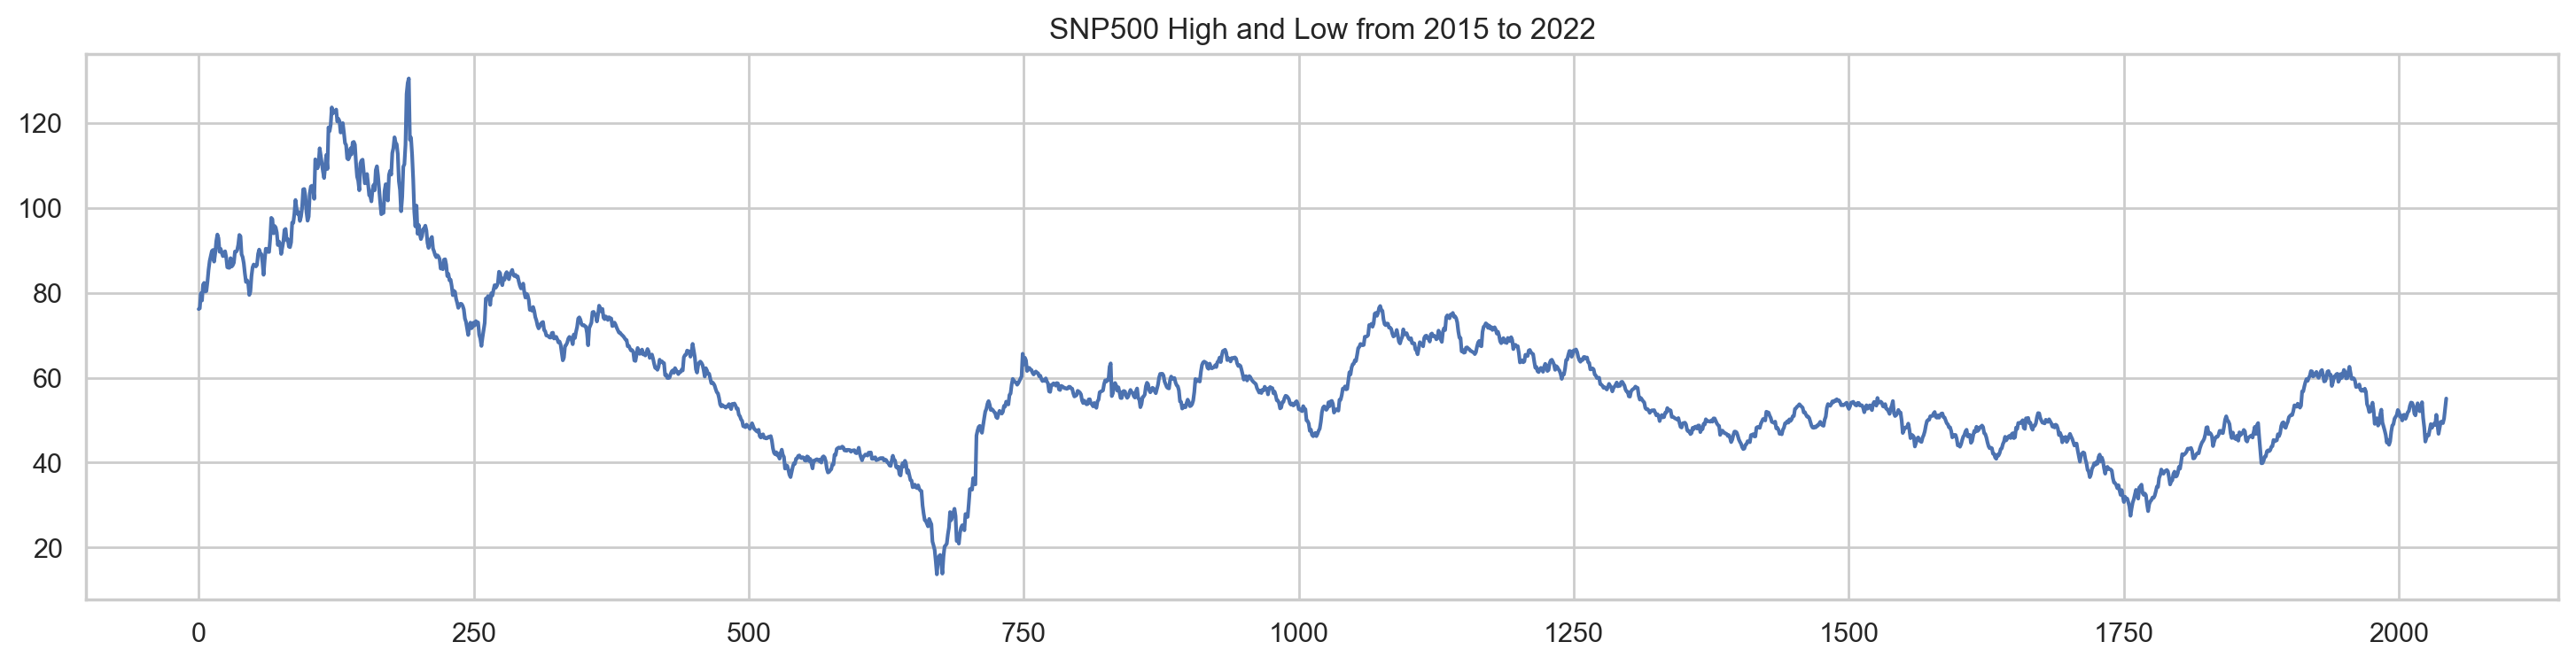

In [312]:

dataset['SNP500_High'].plot()
plt.title("SNP500 High and Low from 2015 to 2022")

### Decomposition

In [313]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dataset['SNP500_High'], model='multiplicative', period = 100)

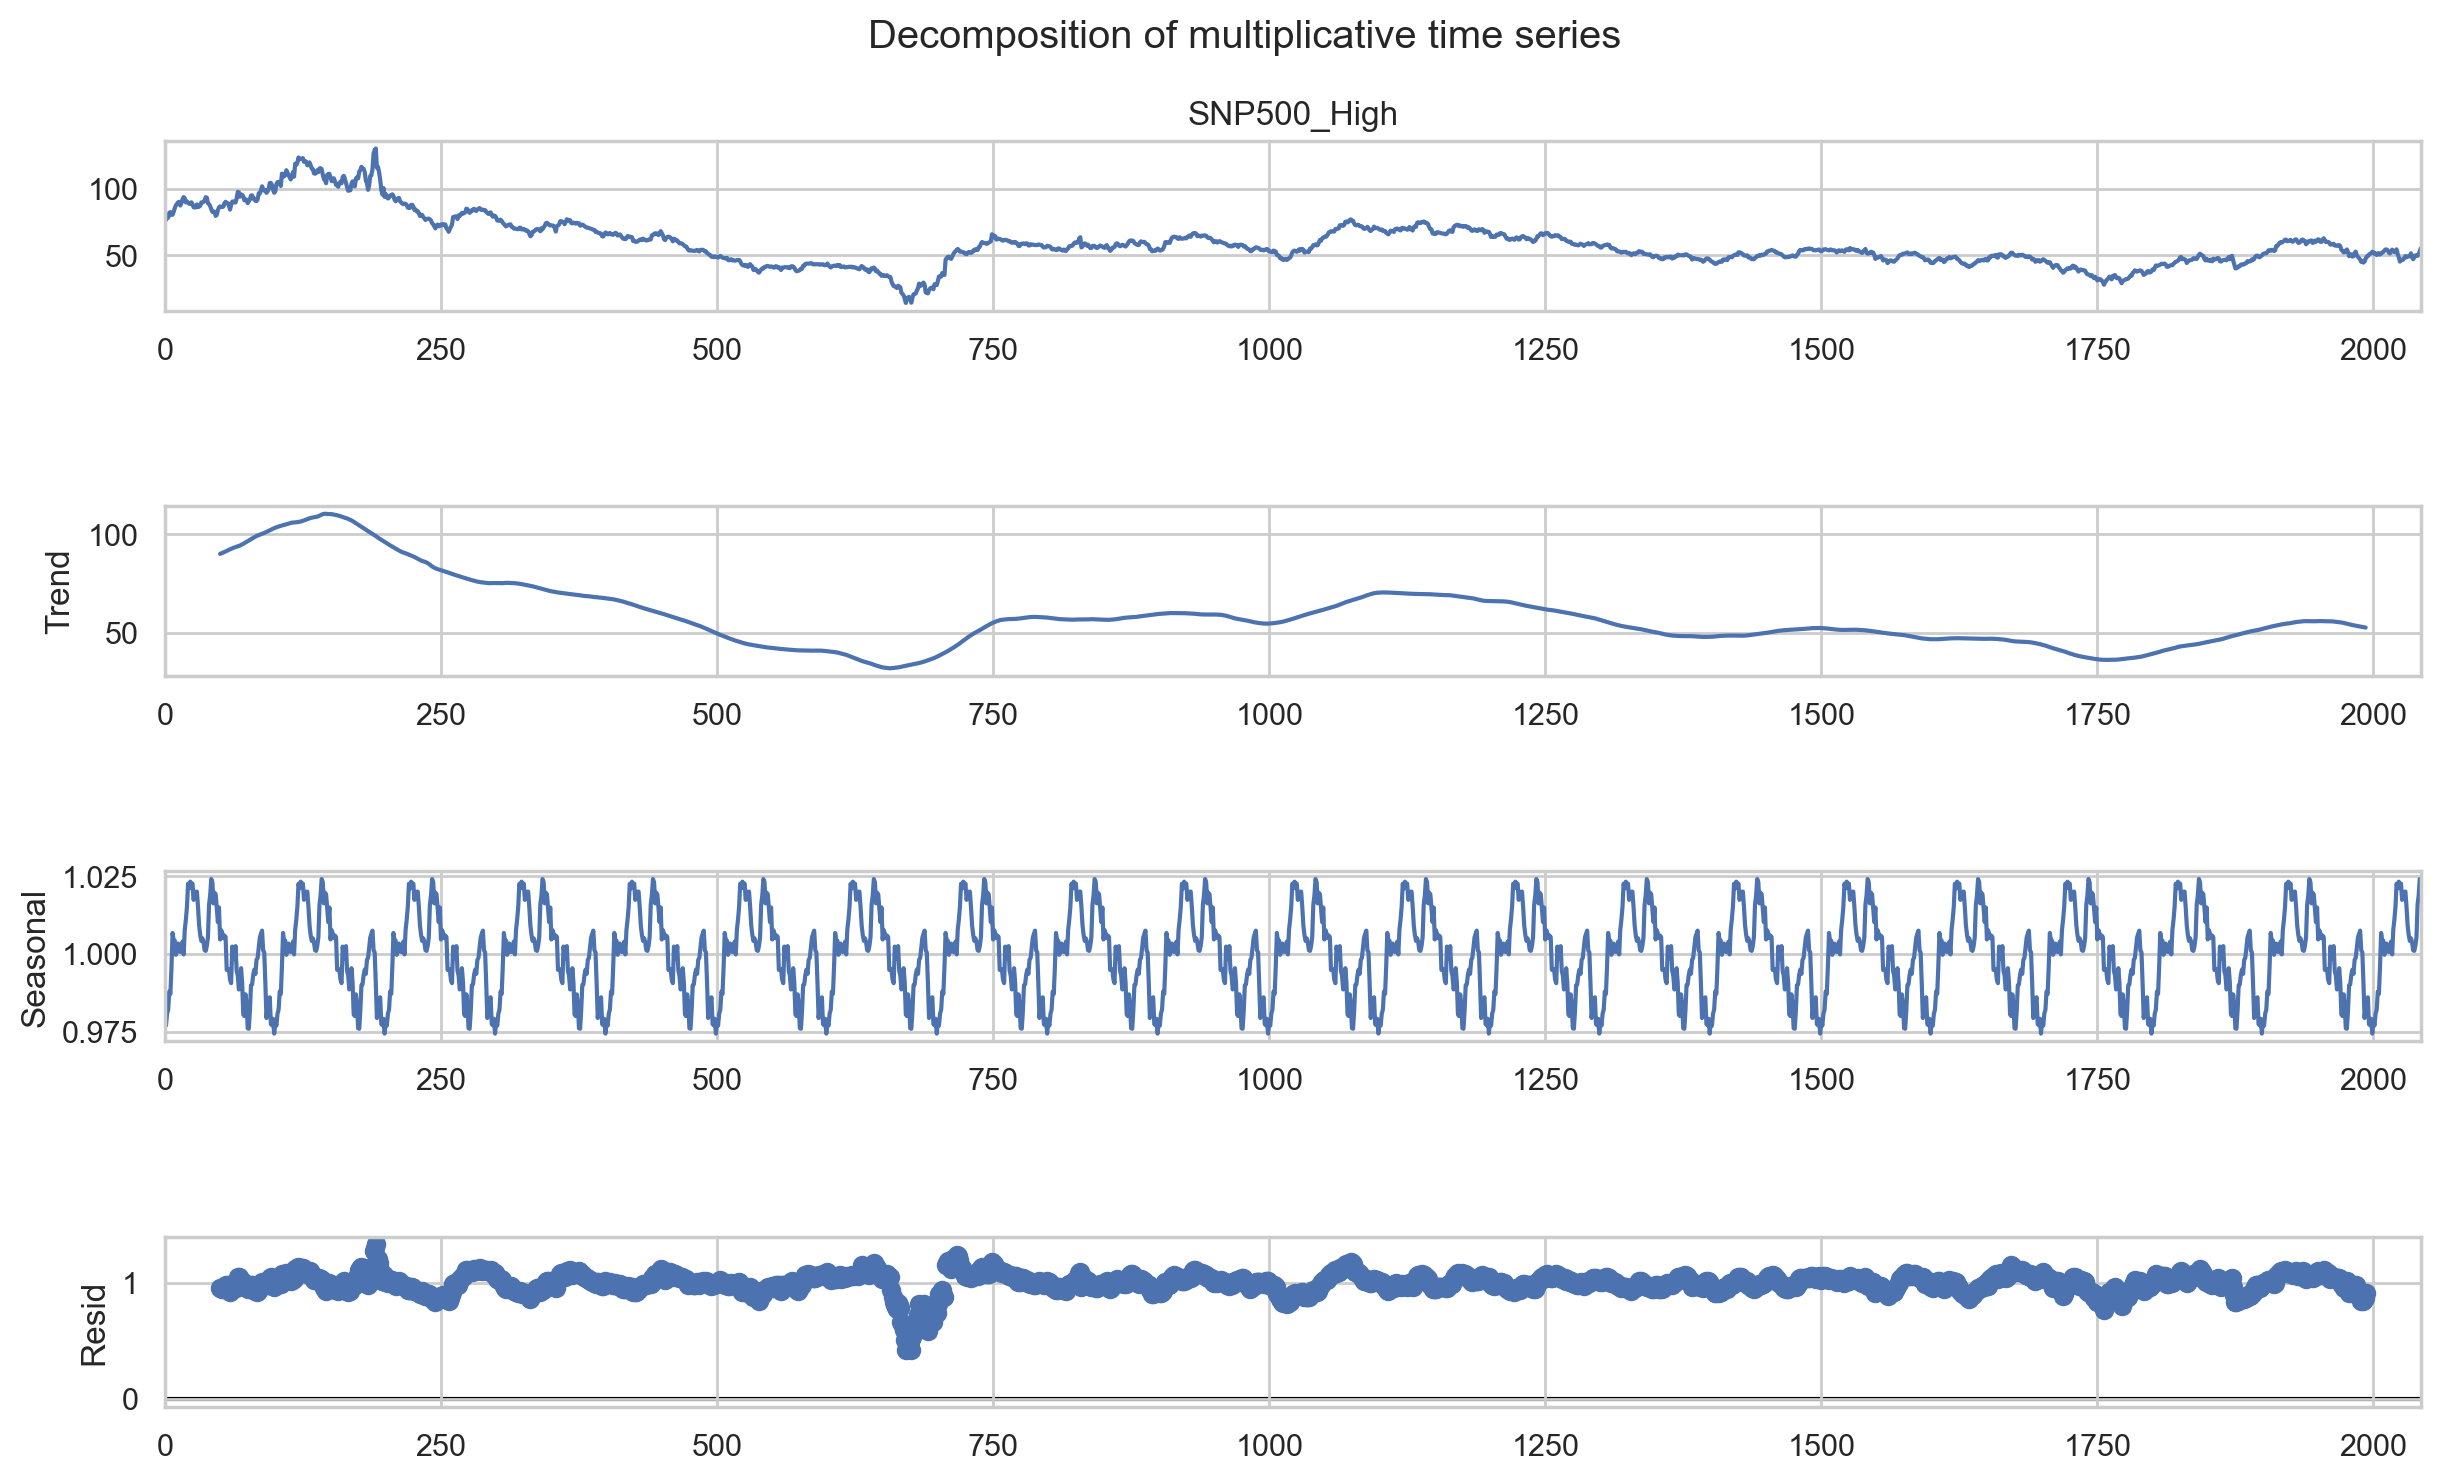

In [314]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series');

**Installing Pyramid **  
[http://pyramid-arima.readthedocs.io/en/latest/setup.html#installation]  
!conda install -c anaconda numpy (If there is an import error with pyramid then update numpy to 1.14)  
!pip install pyramid-arima

In [315]:
from pmdarima import auto_arima

The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [316]:
stepwise_model = auto_arima(dataset['SNP500_High'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.68 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=8313.536, Time=0.51 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=7787.514, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.55 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=8284.064, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=7577.575, Time=0.77 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.76 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.97 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=7613.754, Time=0.65 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=7579.034, Time=0.96 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=7579.084, Time=1.68 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=7577.122, Time=0.71 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=7786.841, Time=0.37 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=5.92 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=i

In [317]:
stepwise_model.aic()

7577.122320333121

The resulting best model parameters gave us an AIC value of 1771.29.

We now have a model that we can fit, in order to do this , we will need training data and test data.

## Train Test Split
We can then fit the stepwise_model object to a training data set. Because this is a time series forecast, we will "chop off" a portion of our latest data and use that as the test set. Then we will train on the rest of the data and forecast into the future. Afterwards we can compare our forecast with the section of data we chopped off.

We'll train on 20 years of data, from the years 1985 - 2015 and test our forecast on the years after that and compare it to the real data:

In [318]:
train = dataset['SNP500_High'].loc['2015-01-01':'2020-01-01']

In [319]:
train.tail()

2016    52.65
2017    53.99
2018    53.16
2019    52.10
2020    52.56
Name: SNP500_High, dtype: float64

In [320]:
test = dataset['SNP500_High'].loc['2020-01-01':]

In [321]:
test.head()

2021    54.24
2022    50.56
2023    48.35
2024    44.96
2025    45.83
Name: SNP500_High, dtype: float64

In [322]:
test.tail()

2039    49.65
2040    49.31
2041    50.37
2042    52.73
2043    55.11
Name: SNP500_High, dtype: float64

## Train the Model
We can then train the model by simply calling `.fit` on the stepwise model and passing in the training data:

In [323]:
len(train), len(test)

(5, 23)

In [324]:
stepwise_model.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

## Evaluation
Now that the model has been fitted to the training data, we can forecast into the future. Recall that our test data set is from 2015-01-01 all the way to 2018-01-01. So if we check the length of our test data we get 37 rows, or 37 time periods. That is the value we will use for our `.predict()` method call:

In [325]:
test_predictions = stepwise_model.predict(n_periods=23)

In [326]:
test_predictions

array([ 52.56      ,  52.56      ,  52.56      ,  52.56      ,
        52.56      ,  52.56      ,  52.56      ,  78.88501316,
        80.22501316,  79.39501316,  78.33501316,  78.79501316,
        78.79501316,  78.79501316,  78.79501316,  78.79501316,
        78.79501316,  78.79501316,  78.79501316, 105.12002632,
       106.46002632, 105.63002632, 104.57002632])

Let's reorganize this set of predictions by creating a dataframe that contains our future forecast and then concatenating that with the original data.

We can then plot this to view how well our prediction forecast matched up with the test set for which we have the real data:

In [327]:
test_predictions = pd.DataFrame(test_predictions, index=test.index, columns=['Prediction'])

In [328]:
test_predictions.head()

,Prediction
2021,52.56
2022,52.56
2023,52.56
2024,52.56
2025,52.56


In [329]:
test.head()

2021    54.24
2022    50.56
2023    48.35
2024    44.96
2025    45.83
Name: SNP500_High, dtype: float64

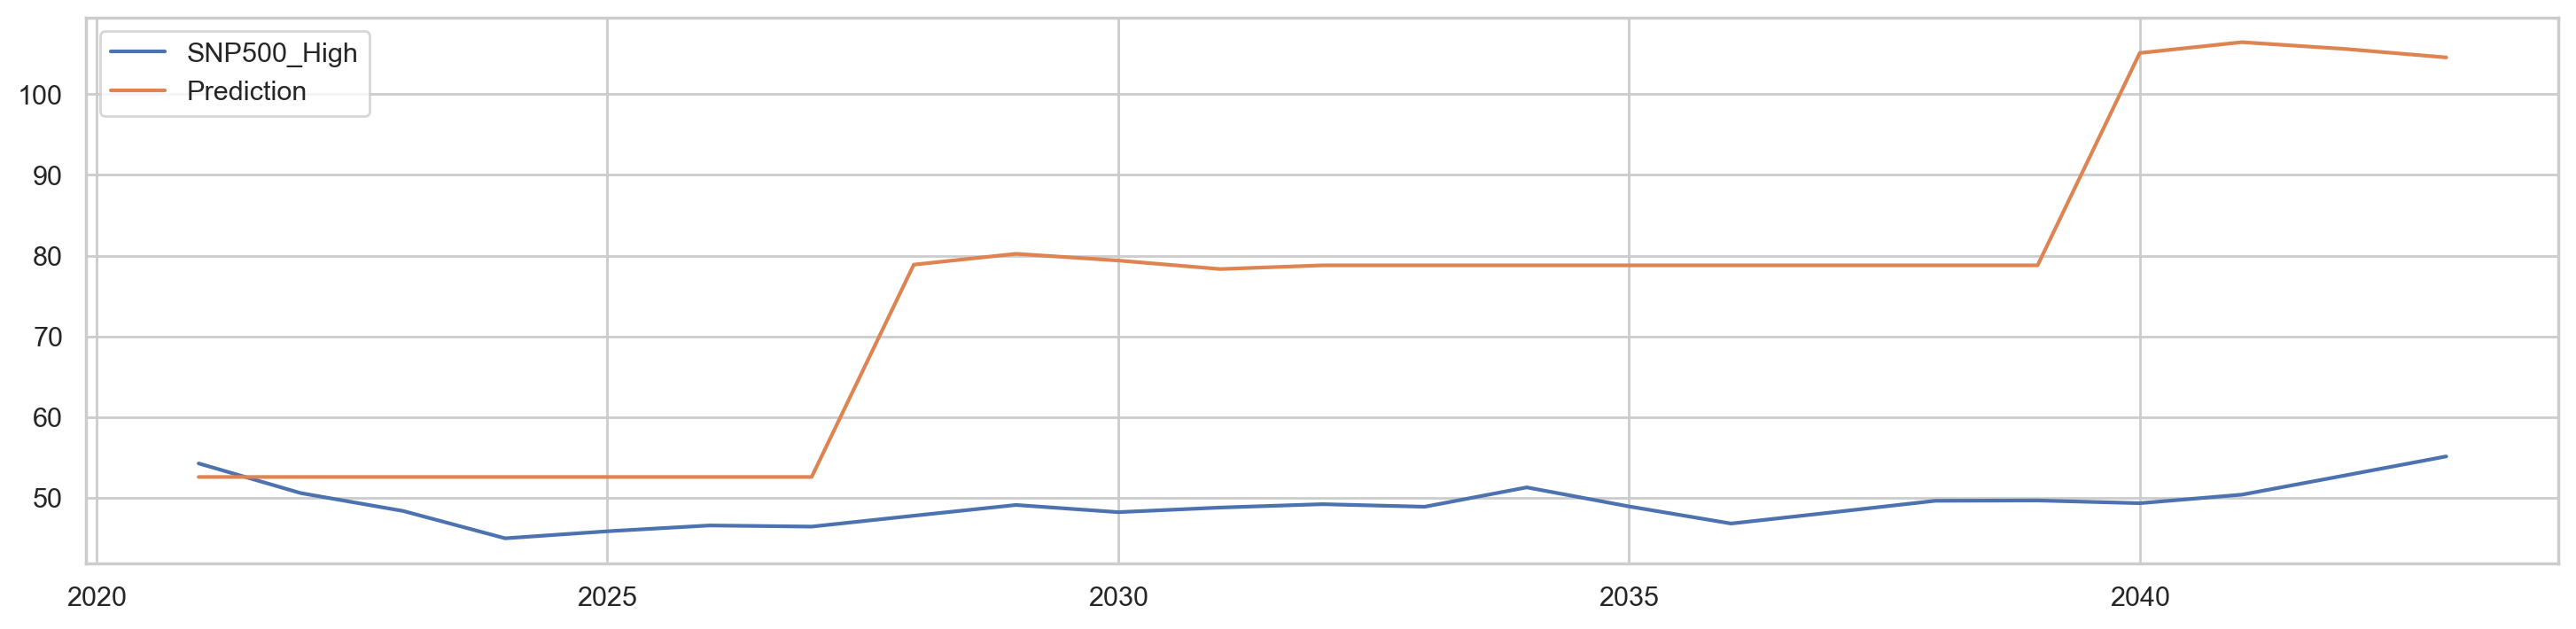

In [330]:
pd.concat([test, test_predictions], axis=1).plot();

We can also just compare this to the entire data set to get a larger picture of the context of our prediction.

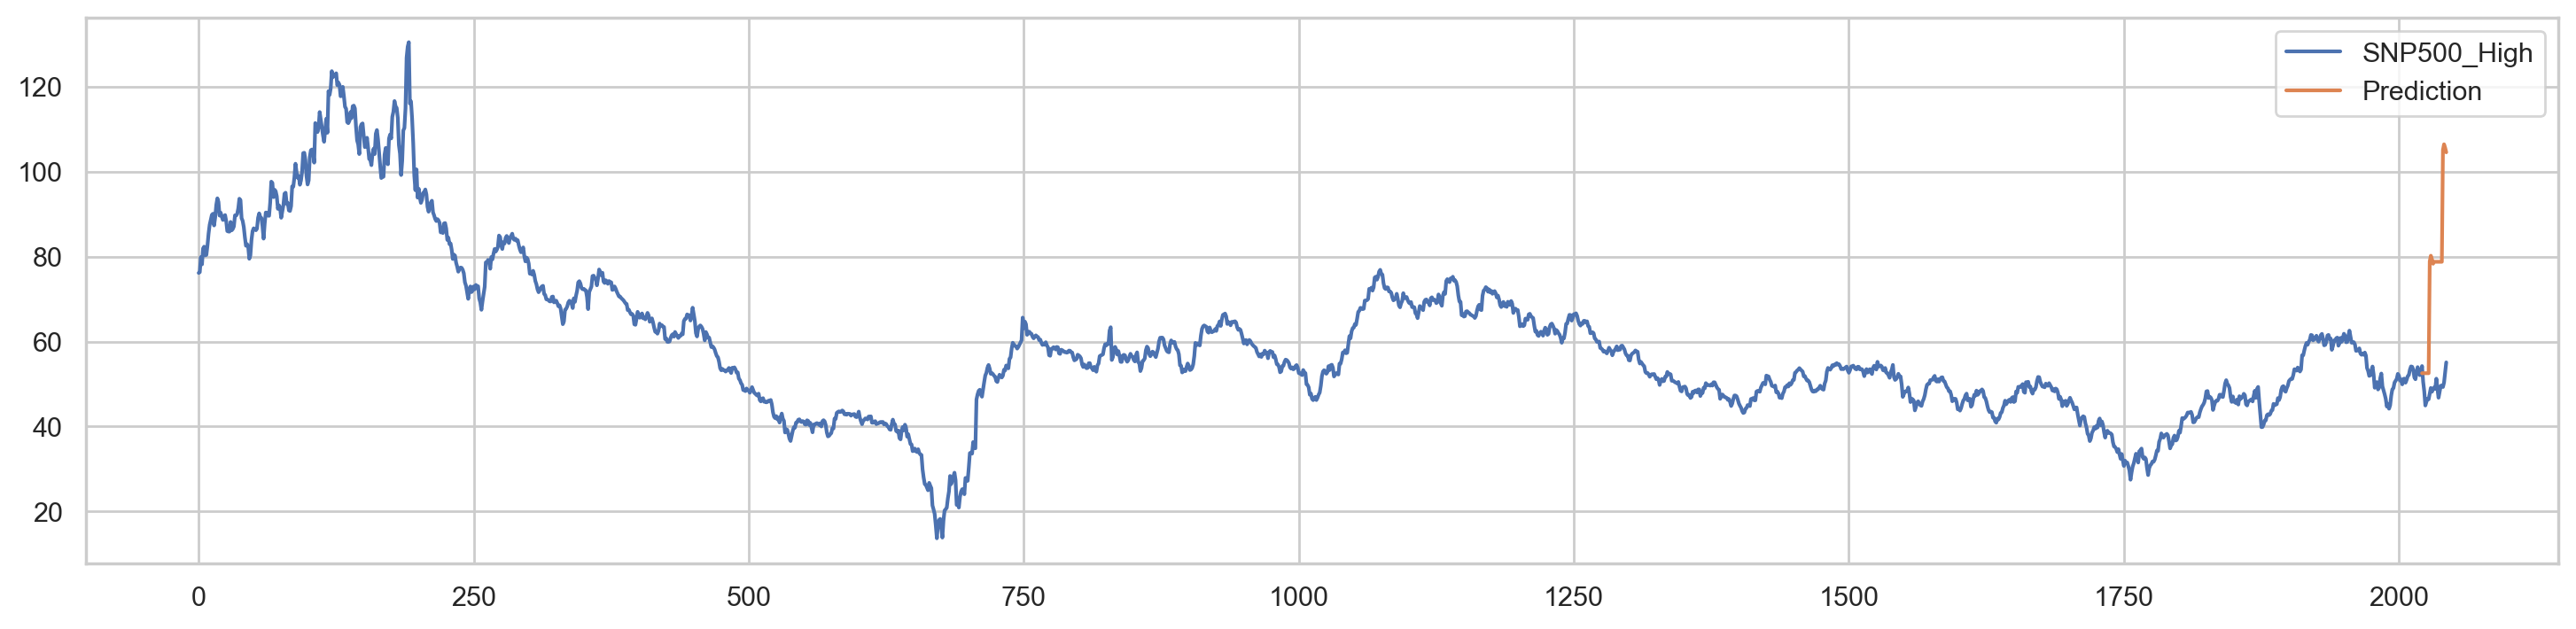

In [331]:
pd.concat([dataset['SNP500_High'], test_predictions], axis=1).plot();

## Next Steps
Now that we've evaluated our data on the test set and our satisfied with the performance, the next step would be to refit our model to our entire data set and then forecast into the real future. We will predict in future for 36 months.

In [358]:
future_forecast = stepwise_model.fit(dataset['SNP500_High']).predict(n_periods=30)

In [359]:
dataset['Date'].iloc[0]

Timestamp('2022-11-28 00:00:00')

In [360]:
future_index = pd.date_range(start=dataset['Date'].iloc[1] + pd.DateOffset(days=1), periods=30, freq='MS')
future_index

DatetimeIndex(['2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01',
               '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01',
               '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01',
               '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01',
               '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01',
               '2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01',
               '2025-04-01', '2025-05-01'],
              dtype='datetime64[ns]', freq='MS')

In [361]:
future_forecast = pd.DataFrame(future_forecast, index=future_index, columns=['Prediction'])

In [362]:
pd.concat([dataset['SNP500_High'], future_forecast], axis=1).tail()

,SNP500_High,Prediction
2025-01-01 00:00:00,NaN,59.631309
2025-02-01 00:00:00,NaN,60.319465
2025-03-01 00:00:00,NaN,58.437709
2025-04-01 00:00:00,NaN,56.284581
2025-05-01 00:00:00,NaN,57.258392


<AxesSubplot:>

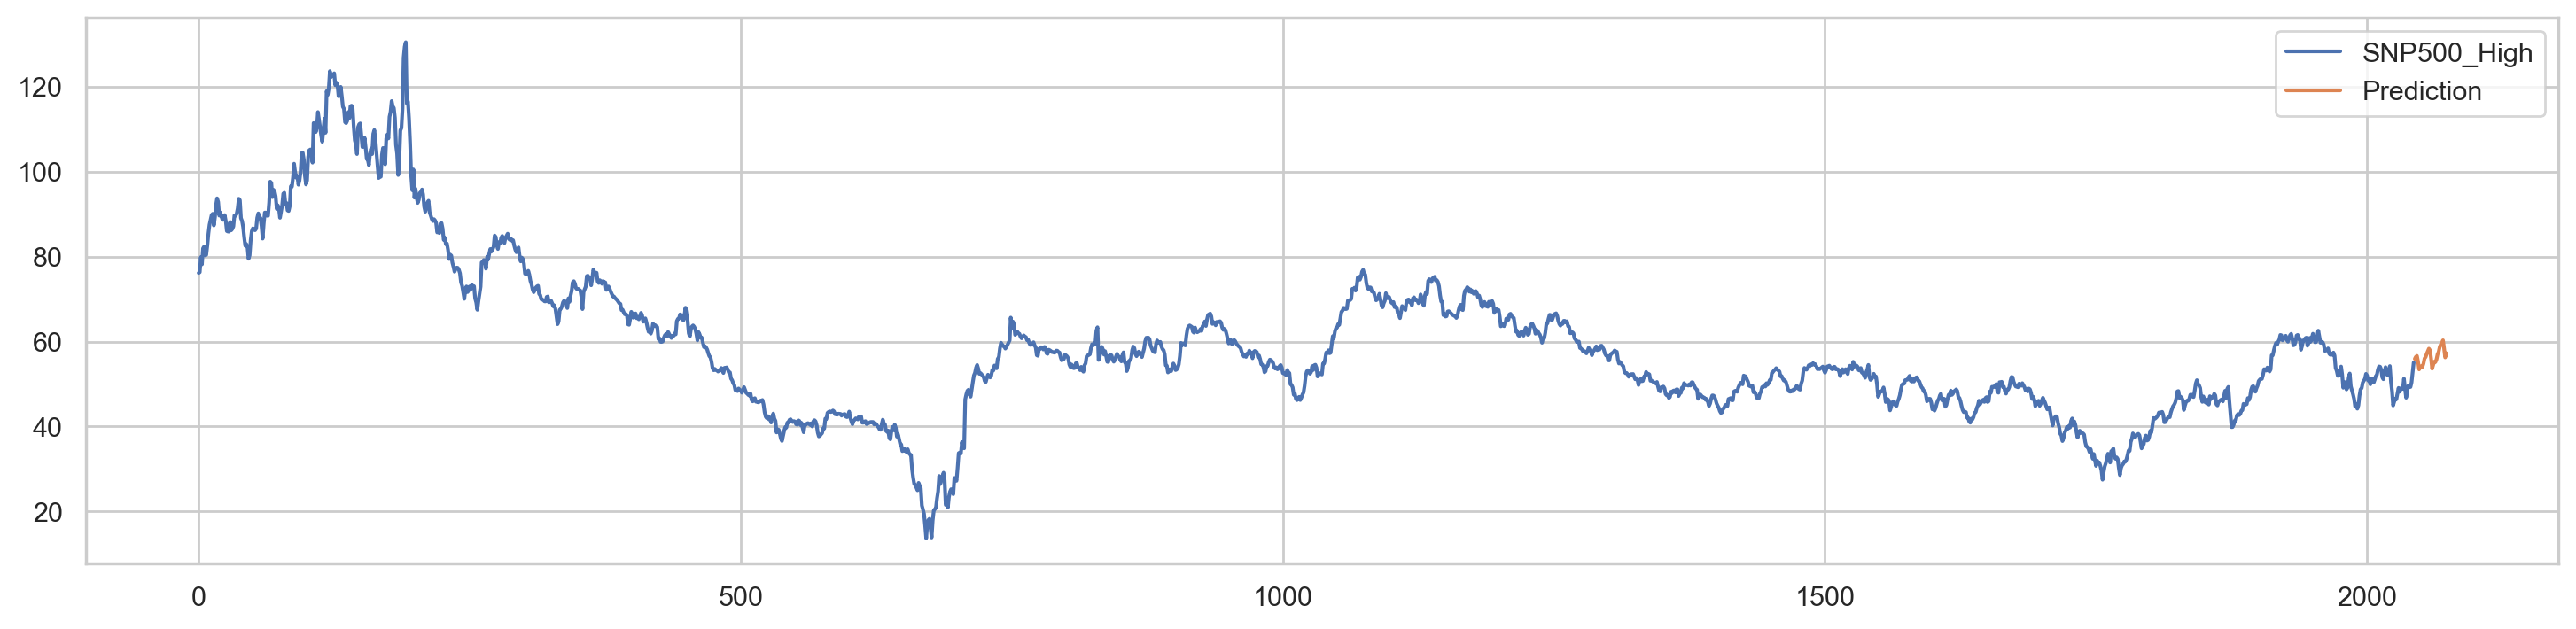

In [363]:
pd.concat([dataset['SNP500_High'], future_forecast], axis=1).plot()